In [891]:
from tqdm import tqdm
from itertools import accumulate
import seaborn as sns

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import os
from scipy import stats
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox

import sklearn
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso, Ridge)
from sklearn.metrics import (r2_score, mean_squared_error)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score)
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures, MinMaxScaler, scale, Normalizer)
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.special import inv_boxcox

path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")

csv_file = os.path.join(path, "student_performance.csv")
df = pd.read_csv(csv_file)

Observe the data.

In [892]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Check for any null values.

In [893]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Let's encode the "Extracurricular Activities" section.

In [894]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].str.strip()  # remove leading/trailing spaces
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


Use the boxplot() function to display the mean, variance and outliers with respect to the price.

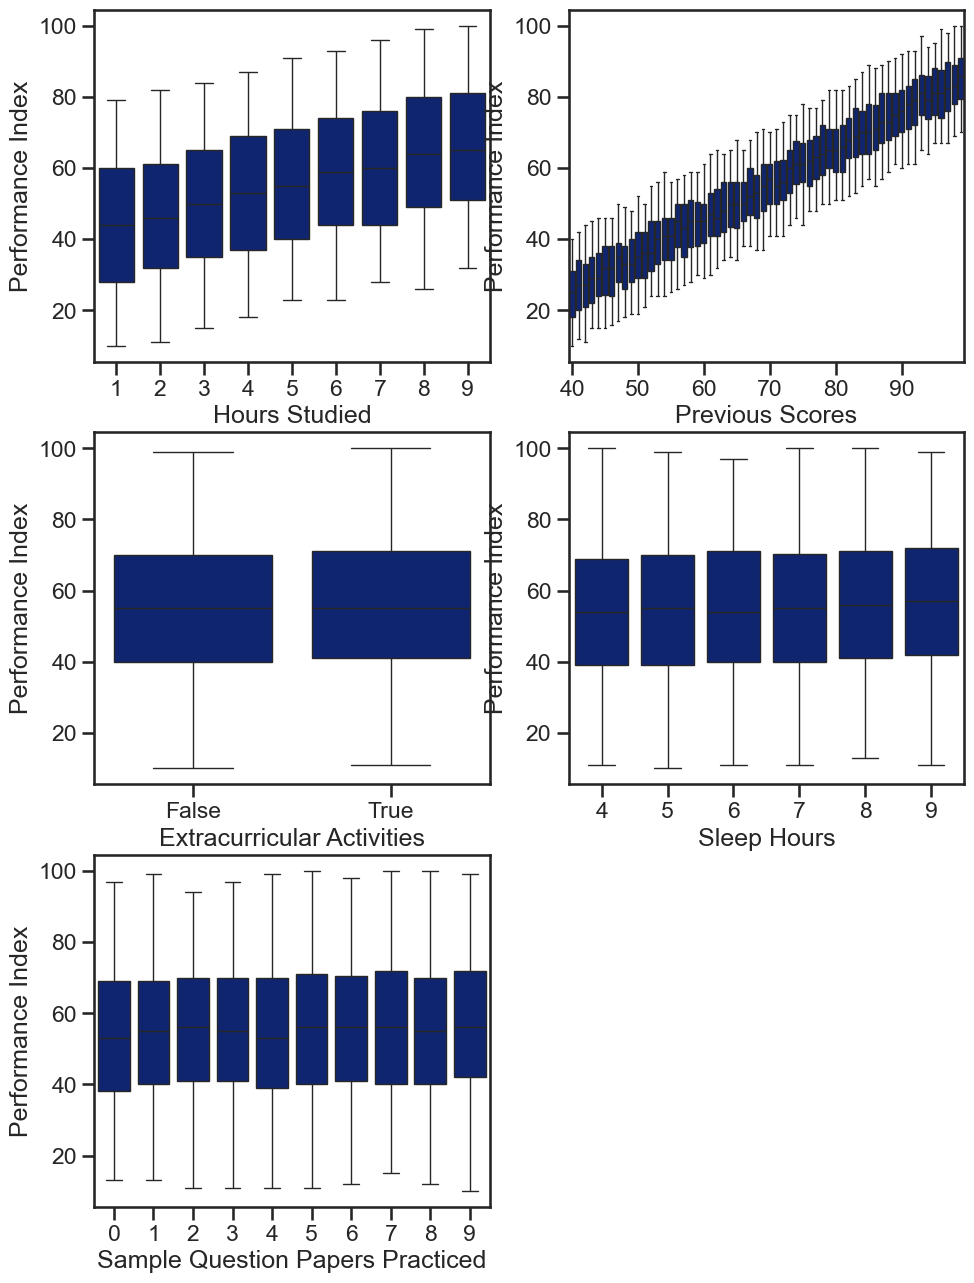

In [895]:
# Create plot figure
plt.figure(figsize=(10,20))

features = [col for col in df.columns if col != "Performance Index"]
axes = [] # store axes objects

for feature in range(len(features)):
    ax = plt.subplot(4,2,feature+1) # create subplot
    sns.boxplot(x = features[feature], y = "Performance Index", data=df, ax=ax)
    axes.append(ax) # append the axes object

# Update Previous Scores X label
ax1_unique_scores = sorted(df['Previous Scores'].unique()) # Sort all unique Previous Scores
ax1_tick_positions = list(range(len(ax1_unique_scores)))[::10] # Select every 10th position
ax1_tick_labels = [ax1_unique_scores[i] for i in ax1_tick_positions]
axes[1].set_xticks(ax1_tick_positions)
axes[1].set_xticklabels(ax1_tick_labels)

# Updated Extracurricular Activities X label
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(["False", "True"]);

Observe the list of top features with high correlation coefficient.

In [896]:
# Compute correlation matrix
corr_matrix = df.corr()

# Sort correlations with Performance Index and covert to DataFrame
corr_matrix["Performance Index"]\
    .sort_values(ascending=False)\
    .to_frame(name="Correlation")

,Correlation
Performance Index,1.000000
Previous Scores,0.915189
Hours Studied,0.373730
Sleep Hours,0.048106
Sample Question Papers Practiced,0.043268
Extracurricular Activities,0.024525


### Linear Assumption

Linear regression requires the relationship between independent variables and the dependent variable to be linear. This assumption may be tested visually with scatter plots and regression lines.

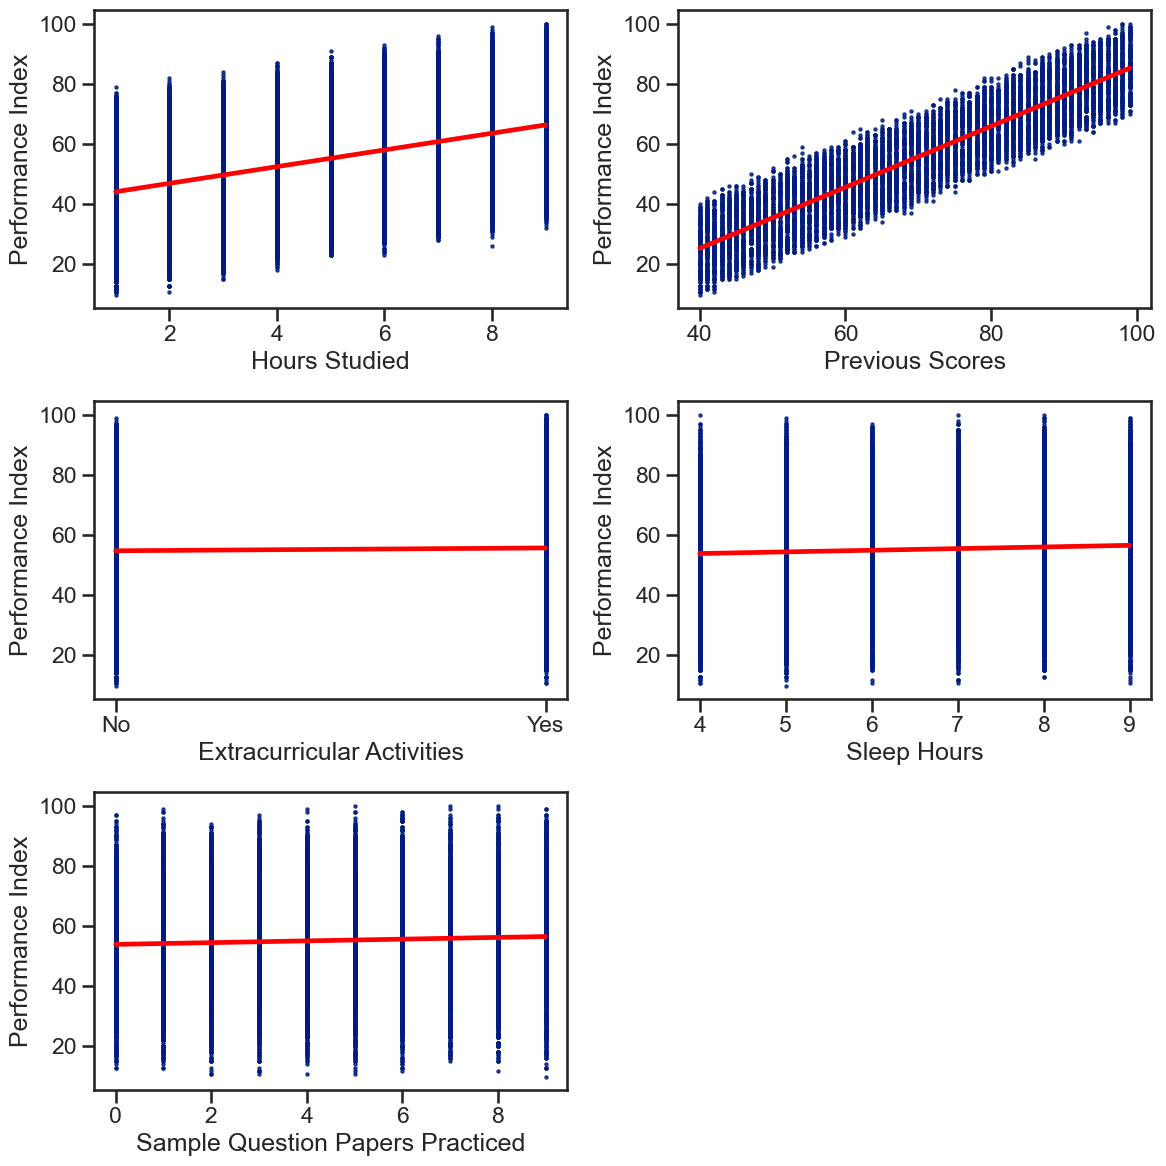

In [897]:
# Create a 3x2 grid of subplots for regression plots
fig, axes = plt.subplots(figsize=(12,12), nrows=3, ncols=2, sharey=False)

# Generate all features and subplot positions
positions = [(rows, columns) for rows in range(3) for columns in range(2)]

for feature, position in zip(features, positions):
    ax = axes[position]
    # Create regression plot
    sns.regplot(x=df[feature], y=df["Performance Index"],
                ax=ax, scatter_kws={"s": 5}, line_kws={"color": "red"})

# Customize x-axis for Extracurricular Activities
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(["No", "Yes"])

# Hide empty subplot
axes[2,1].axis('off')

plt.tight_layout()
plt.show()

The plots above depict a dispersed distribution of performances across sleep hours and sample question papers practiced. However, there is some linear correlation in hours studied and previous scores.

### Homoscedasticity

The assumption of homocedasticity (constant varaince) describes the varaince between the independent variables and dependent variables is the same across all values of the independent variable.

This means there is a constant variance present in the response variable as the predictor variable increases.

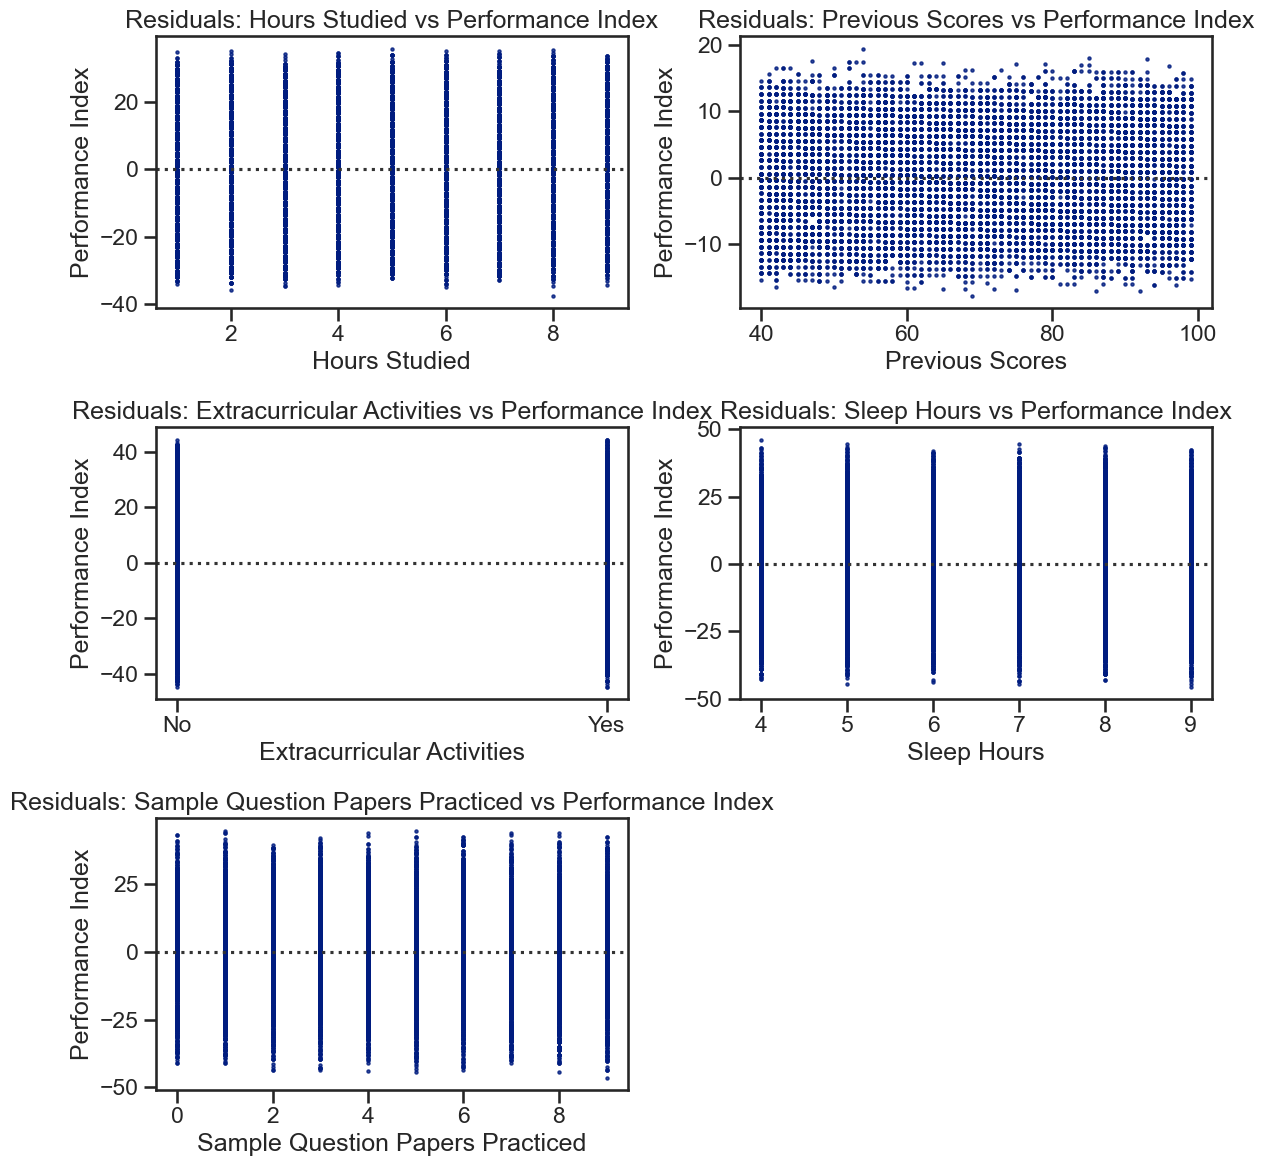

In [898]:
# Create a 3x2 grid of subplots for residual plots
fig, axes = plt.subplots(figsize=(12,12), nrows=3, ncols=2, sharey=False)

#Generate all features and subplot positions
positions = [(rows, columns) for rows in range(3) for columns in range(2)]

for feature, position in zip(features, positions):
    ax = axes[position]
    # Create residual plot
    sns.residplot(x=df[feature], y=df["Performance Index"],
                  ax=ax, scatter_kws={"s":5})
    ax.set_title(f"Residuals: {feature} vs Performance Index")

# Customize x-axis for Extracurricular Activities
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(["No", "Yes"])

# Hide empty subplot
axes[2,1].axis('off')

plt.tight_layout()
plt.show()


The plots above also depict a dispersed error variance with no clear structure. Therefore, the assumption of homoscedasticity is not met.

### Normality
Linear regression analysis demands that the dependent variable is normally distributed. A histogram, box-plot or a Q-Q-Plot can verify this normal distribution. The goodness of fit test also checks ofr normality in the dependent variable.

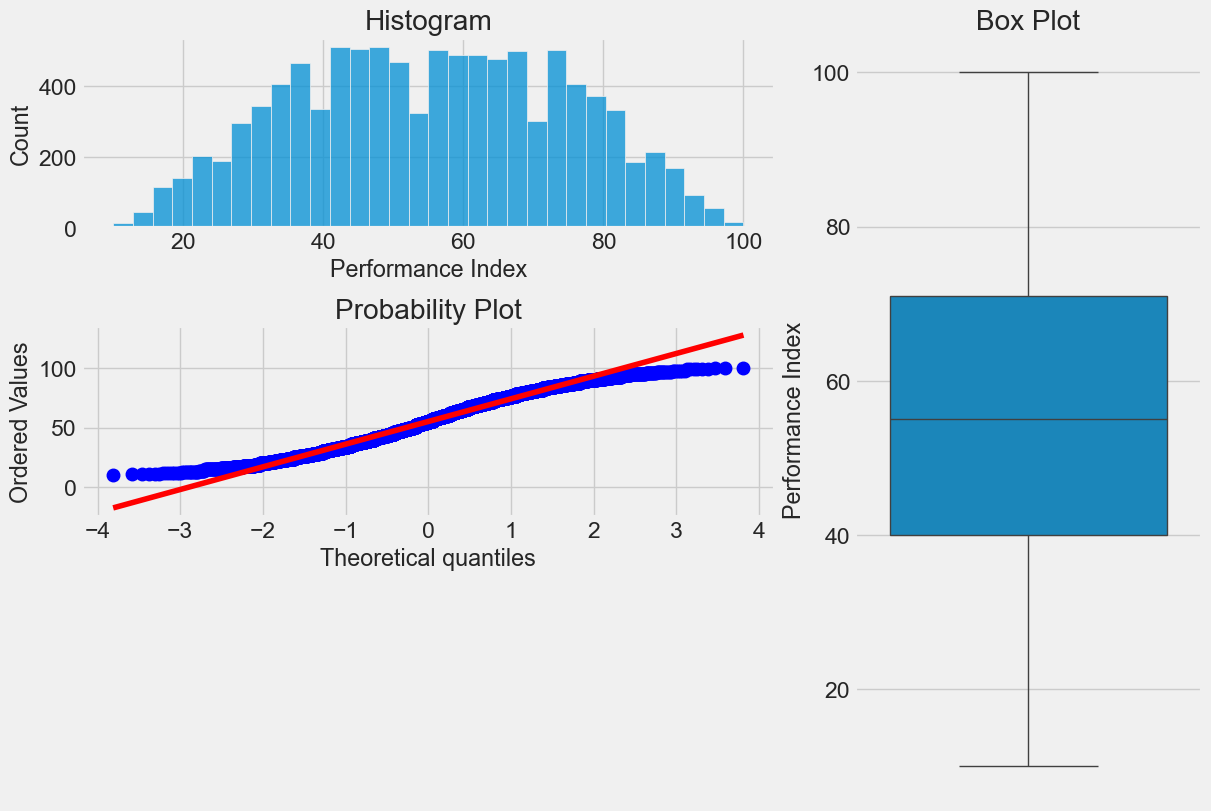

In [899]:
def plot_normality_charts(data, feature):
    style.use('fivethirtyeight')

    # Create a customized chart
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    # Create the histogram
    ax1 = fig.add_subplot(grid[0,:2])
    ax1.set_title('Histogram')
    sns.histplot(data.loc[:,feature], ax=ax1)

    # Create the QQ_Plot
    ax2 = fig.add_subplot(grid[1,:2])
    ax2.set_title('QQ_plot')
    stats.probplot(data.loc[:,feature], plot=ax2)

    # Create the Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(data.loc[:,feature], orient='v', ax=ax3)

plot_normality_charts(df,'Performance Index')
    

The three charts above visually tell us that our target variable is somewhat normally distributed.

These plots show that the assumption for accurate linear regression modelling can be met with some adjustments.

Also observe normality with a statistical test, using a p_value.

The higher the p_value is the closer the distribution is to normal. Frequentist statistics accept a normal distribution (fail to reject the null hypothesis that it is normal) if p > 0.05.

In [900]:
normaltest(df["Performance Index"].values)

NormaltestResult(statistic=np.float64(1130.853463374274), pvalue=np.float64(2.7434086755662947e-246))

The p-value is extremely low. The target variable (performance index) is not normally distributed.

Linear regression assumes a normally distributed residuals which is aided by transforming the target variable.

Use the log transformation to normalize our y-variable.

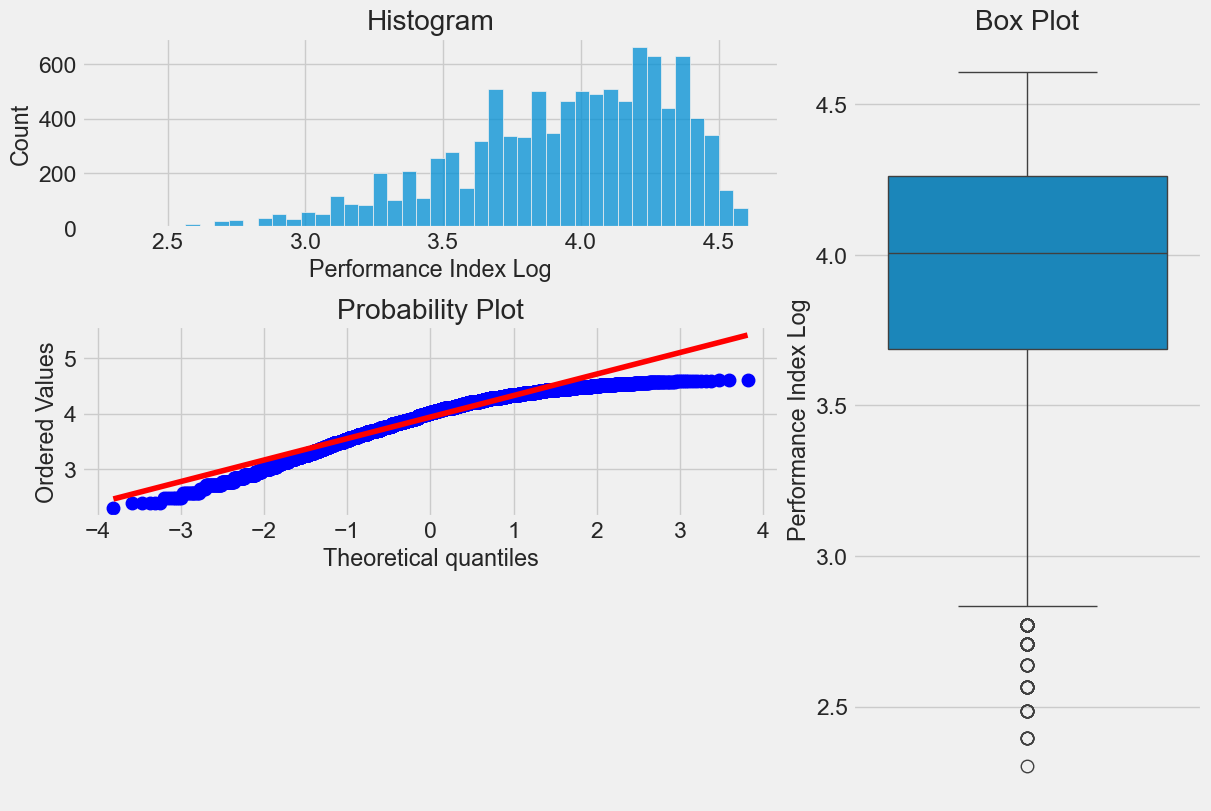

In [901]:
# Create new statistics dataframe
stats_df = pd.DataFrame()

stats_df['Performance Index Log'] = np.log(df["Performance Index"])
plot_normality_charts(stats_df, 'Performance Index Log')

In [902]:
normaltest(stats_df['Performance Index Log'])

NormaltestResult(statistic=np.float64(840.915446448985), pvalue=np.float64(2.4976462625712126e-183))

The output is closer to normal distribution. It transformed the performance index distrubiton to a more symmetrical curve.

Also apply the square root transformation to normalize our data.

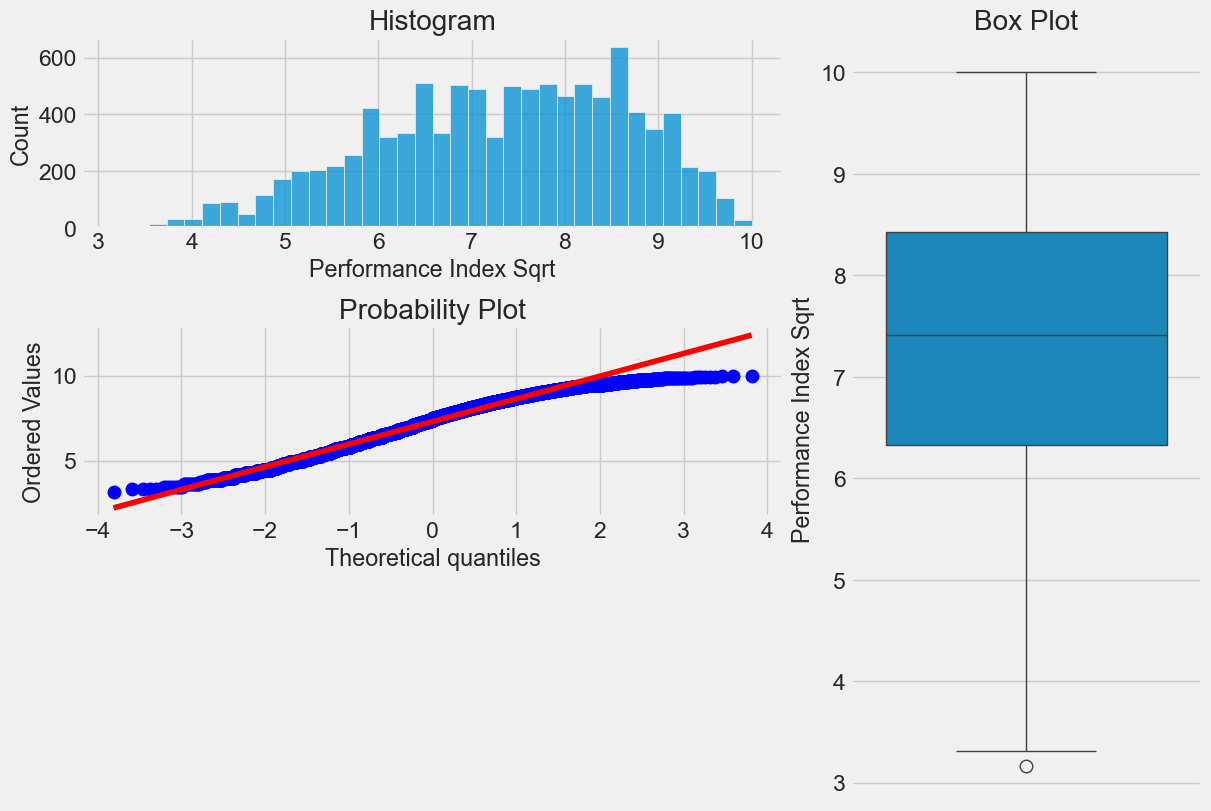

In [903]:
stats_df['Performance Index Sqrt'] = np.sqrt(df["Performance Index"])
plot_normality_charts(stats_df, 'Performance Index Sqrt')

In [904]:
normaltest(stats_df['Performance Index Sqrt'])

NormaltestResult(statistic=np.float64(499.17033016395607), pvalue=np.float64(4.041476333777599e-109))

The output is even closer to normal distribution.

Observe the box cox transformation, which is a generalization of the square root function, optimizing the exponent degree.

The optimized lambda value is 0.8563766988840682.


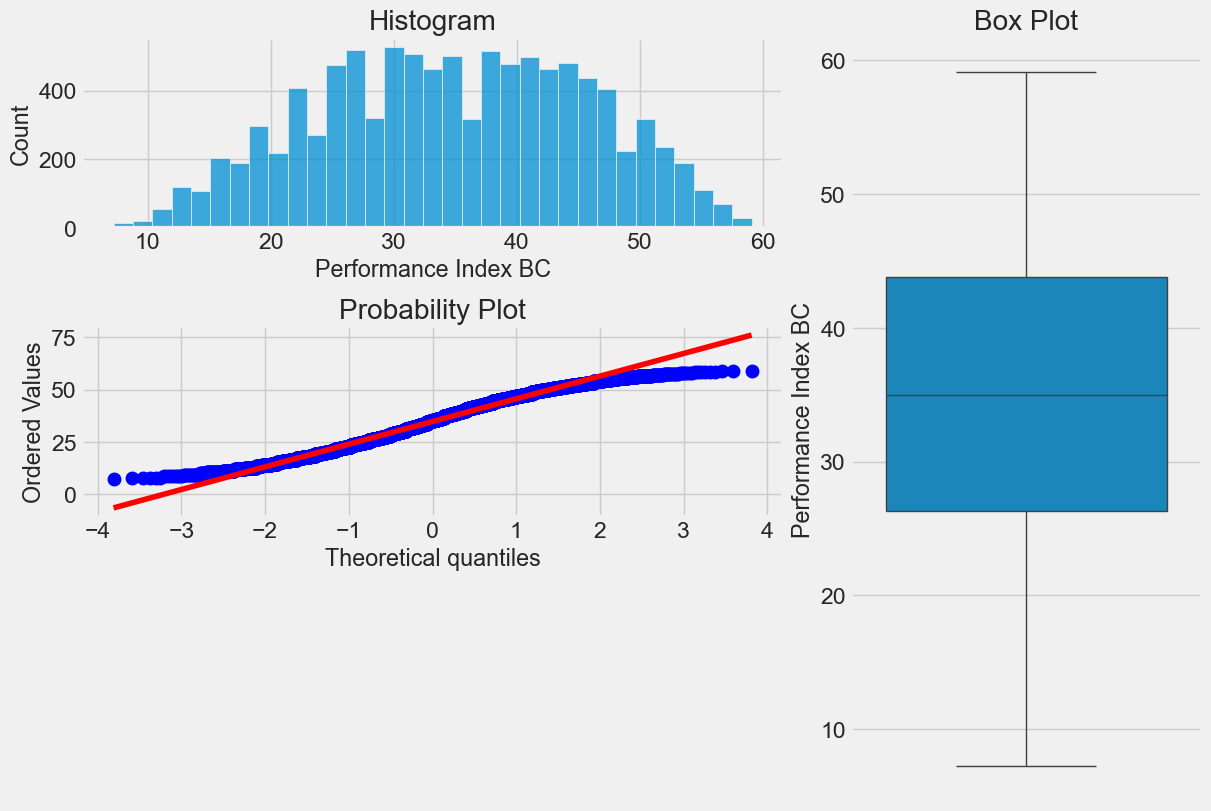

In [905]:
# Compute boxcox values
stats_df['Performance Index BC'], Performance_Index_Lambda = boxcox(df["Performance Index"])

# Print results
print(f"The optimized lambda value is {Performance_Index_Lambda}.")
plot_normality_charts(stats_df, 'Performance Index BC')

Also use the inverse boxcox function to use these in a regression context.

In [906]:
print(np.round(inv_boxcox(stats_df['Performance Index BC'], Performance_Index_Lambda),0)[:10])
print(df["Performance Index"].values[:10])

0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
5    61.0
6    63.0
7    42.0
8    61.0
9    69.0
Name: Performance Index BC, dtype: float64
[91. 65. 45. 36. 66. 61. 63. 42. 61. 69.]


In [907]:
print(normaltest(stats_df['Performance Index BC']))

NormaltestResult(statistic=np.float64(959.0139022648967), pvalue=np.float64(5.65948729000443e-209))


The box cox results show that it only mildly normalizes the distribution.

We find that the square root trnasformation is most effective in nomralizing or distribution.

### 4. Multicollinearity

Multicollinearity occurs when there is a strong correlation between the independent variables. Linear regression requires independent variables to have little or no similar features.

Multicollinearity leads to
- The effect of predictor varaibles dependent on other variables included in the model
- Predictors are volatile and highly sensitive to small changes in sample
- Inability to interpret a coefficient on a variable because one variable's change lead to a conditional change in another variable

Use a heatmap to identify multicollinearity presence.

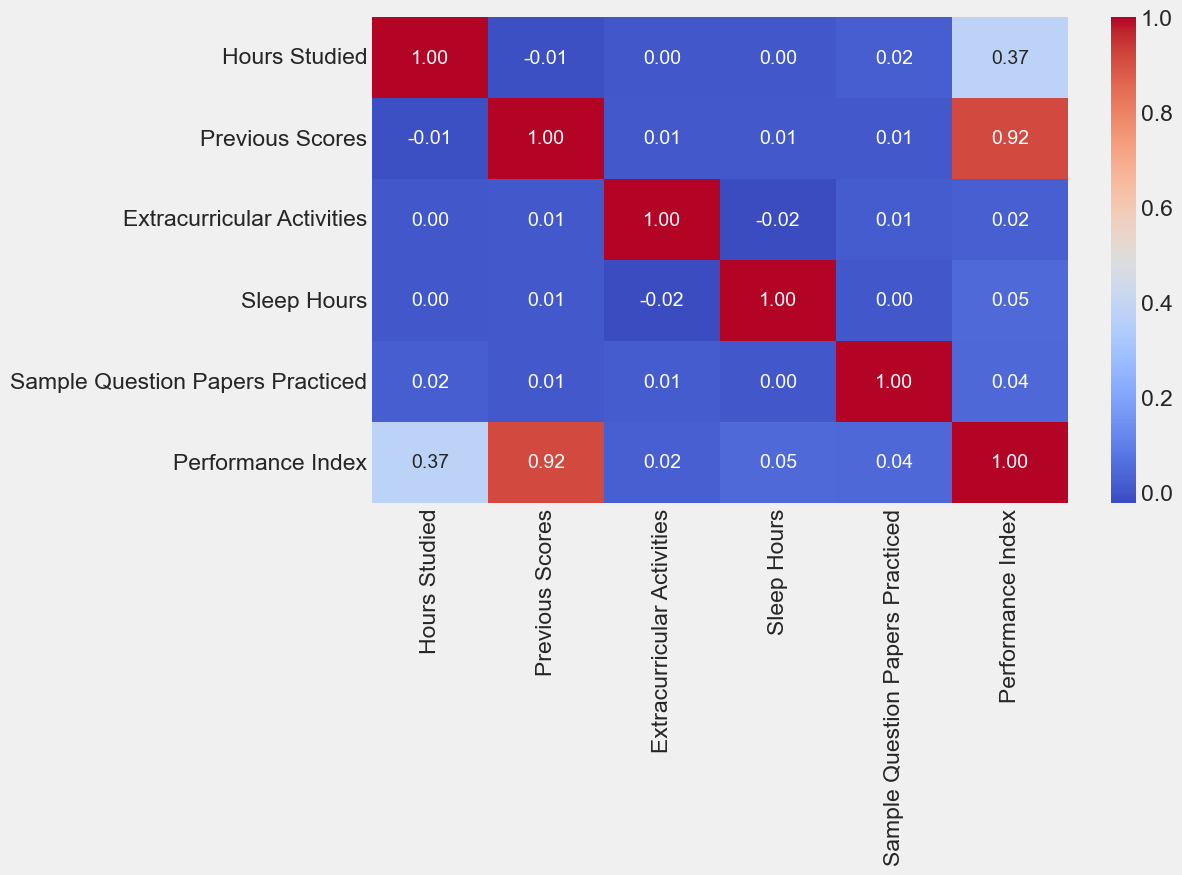

In [908]:
# Create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

As observable, there is multicollinearity present, though rare and far in-between.

Perform regression using transformed target variables.

In [909]:
# Define and load predictor (x) and target (y) variables
y_col = "Performance Index"
x = df.drop(y_col, axis=1)
y = df[y_col]

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6767)

# Noramlize the data using Standard Scaler
s = StandardScaler()
x_train_s = s.fit_transform(x_train)
x_test_s = s.transform(x_test)

# Fit regression
lr = LinearRegression()
lr.fit(x_train_s, y_train)

#Predict on testing data
y_pred = lr.predict(x_test_s)

Now assess the results using the r2_score, also known as the goodness of fit of the model, and calculate the accuracy.

In [910]:
print (f"R2 Score: {r2_score(y_test,y_pred)}")
print (f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.9892896478572177
MSE: 3.9933076708869484


That's a high R2 score.

Also use a Pipeline object and apply a set of transformations and linear regression, simplifying the steps of processing data.

In [911]:
# Define pipeline steps
steps = [('scaler', StandardScaler()), ('lr', LinearRegression())]

# Input the list as an argument to the pipeline
pipe = Pipeline (steps=steps)

# Fit the constructor
pipe.fit(x_train, y_train)

# Make a prediction
y_pred = pipe.predict(x_test)

#Assess accuracy using R2 Score
print(f"R2 Score: {r2_score(y_test, y_pred)}")

#Assess accuracy using RMSE score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print (f"RMSE: {rmse}")


R2 Score: 0.9892896478572177
RMSE: 1.9983262173346343


Plot the predictions vs actual for our pipeline.

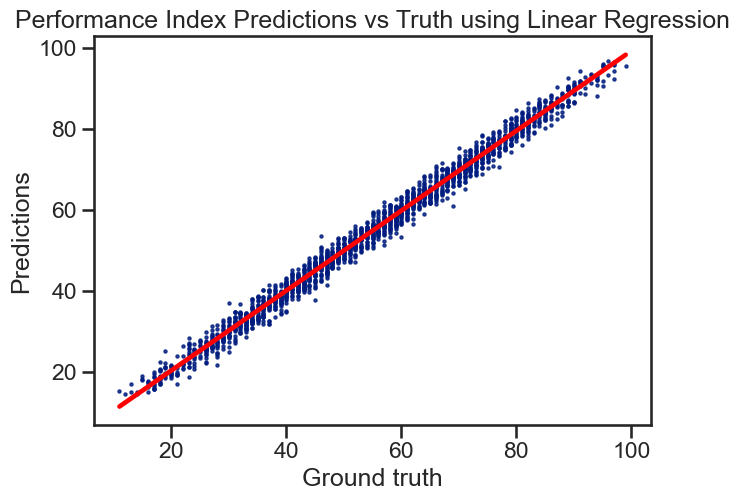

In [912]:
# Configure SNS Style
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

#Build plot
ax = plt.axes()
sns.regplot(x=y_test, y=y_pred, ax=ax, scatter_kws={"s":5}, line_kws={"color":"red"})
ax.set(xlabel='Ground truth',
       ylabel='Predictions',
       title='Performance Index Predictions vs Truth using Linear Regression');

## Polynomial Regression

A linear model may also be used to fit nonlinear data. This can be performed by adding powers of each feature as new features, and training a linear model on the extended set of features.

When determining model performance, it is important to be weary of overfitting - when the model is too complex and performs well on training data but not on test data. Underfitting is when the model is too simple and performs poorly on both data sets.

Over fitting can be fixed with using methods like regularization.

Under fitting can be approached with using more complex models like polynomial regression.

In [913]:
# This function plots the distribution of two inputs
def plot_distribution(actual, predicted):
    plt.figure()

    # Graph actual vs predicted figures
    ax = sns.kdeplot(actual, color="r", label="Actual Value")
    sns.kdeplot(predicted, color="b", label="Fitted Values", ax=ax)

    # Customize plot
    plt.legend()
    plt.title('Actual vs Fitted Values')
    plt.show()
    plt.close()

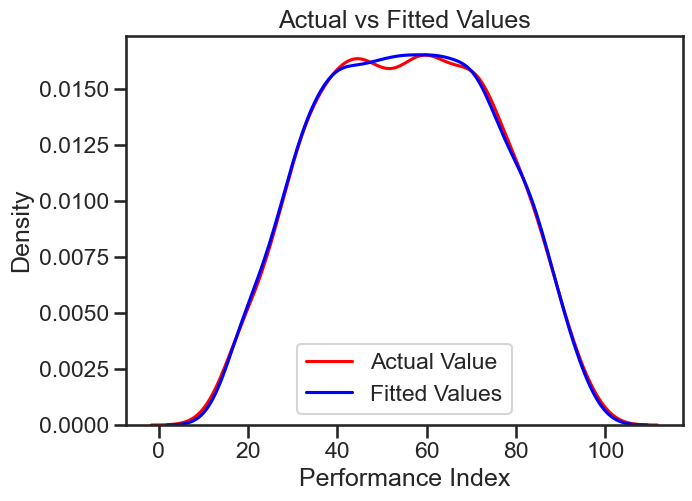

In [914]:
plot_distribution(y_test, y_pred)

In [915]:
# View the estimated coefficients for linear regression
{col:coef for col,coef in zip(x.columns, lr.coef_)}

{'Hours Studied': np.float64(7.376395484217225),
 'Previous Scores': np.float64(17.66012420431953),
 'Extracurricular Activities': np.float64(0.31527489517882146),
 'Sleep Hours': np.float64(0.8002386931196593),
 'Sample Question Papers Practiced': np.float64(0.5340274961865328)}

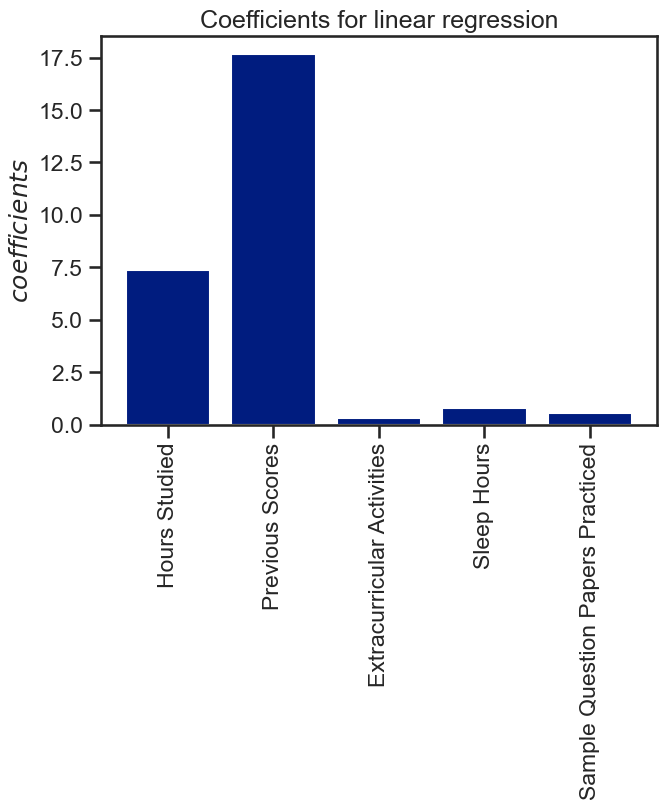

In [916]:
# Plot the estimated coefficients for linear regression
plt.bar(x.columns, abs(lr.coef_[:len(x.columns)]))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.title("Coefficients for linear regression")
plt.show()

We can also train the model and plot the R2 for each feature on the training and test data sets.

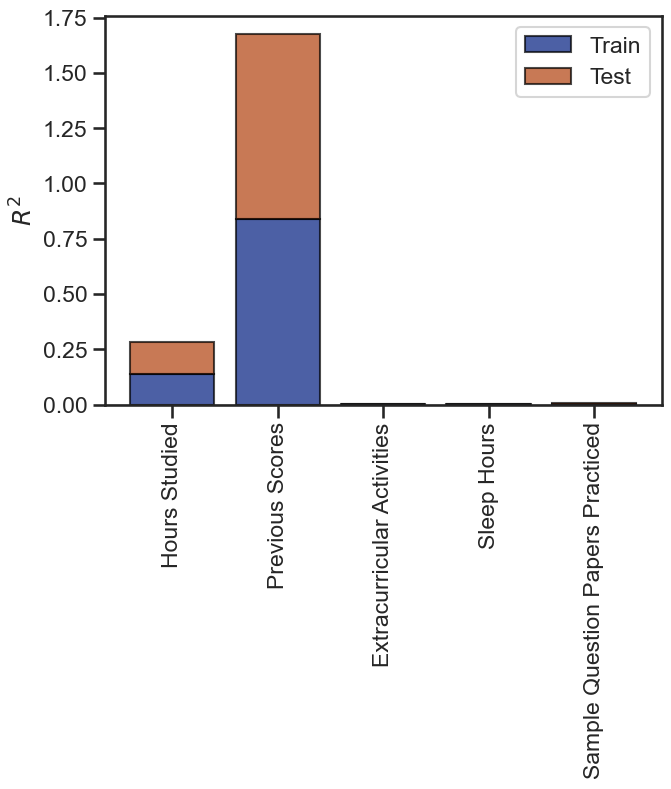

Training R^2 mean value: 0.19597314222993942
      Testing R^2 mean value: 0.19805117206887907
Training R^2 max value: 0.8377492983283459
      Testing R^2 max value: 0.8368372541263911


In [917]:
features=list(x)
R_2_train=[]
R_2_test=[]

for feature in features:
    # Fit the model
    lr.fit(x_train[[feature]],y_train)
    
    # Evaluate the model
    R_2_train.append(lr.score(x_train[[feature]],y_train))
    R_2_test.append(lr.score(x_test[[feature]],y_test))

# Plot out bars
plt.bar(features,R_2_train,label="Train", alpha=0.7, edgecolor="black")
plt.bar(features,R_2_test,label="Test", bottom=R_2_train, alpha=0.7, edgecolor="black")

# Customize graph
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()

# Display summary
print("Training R^2 mean value: {}\n\
      Testing R^2 mean value: {}"
    .format(str(np.mean(R_2_train)),
            str(np.mean(R_2_test))) )

print("Training R^2 max value: {}\n\
      Testing R^2 max value: {}"
    .format(str(np.max(R_2_train)),
            str(np.max(R_2_test))))

The plot above depicts that larger co-efficients tend to correspond to a larger R2.

Use GridSearch to optimize the hyper-parameters of the model by using cross-validation methods of the parameter gridd.

In [918]:
steps = [('polynomial', PolynomialFeatures(include_bias=False, degree=2)),
         ('scaler', StandardScaler()),
         ('model', LinearRegression())]
pipe = Pipeline(steps=steps)

Create a GridSearchCV object with the dictionary of parameter values to search for the best combination of hyperparameters.

In [919]:
param_grid = {
    "polynomial__degree": [1,2,3,4], # Polynomial degrees
    "model__fit_intercept": [True, False] # Whether the model learns a bias term (intercept)or forces it to pass through the origin
}

search = GridSearchCV(pipe, param_grid, scoring="r2", cv=5, n_jobs=1) # 5-fold cross-validation and 1 CPU core

In [920]:
search.fit(x_train, y_train) # Train GridSearch

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'polynomial__degree': [1, 2, ...]}"
,scoring,'r2'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,1


This finds the best parameter values on the training dataset.

Then, obtain the estimator with the best parameters and assign it to a variable.

In [921]:
best_lr = search.best_estimator_ # Determine the best parameters
best_lr

,steps,"[('polynomial', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,1
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


R2 Score: 0.9892896478572177


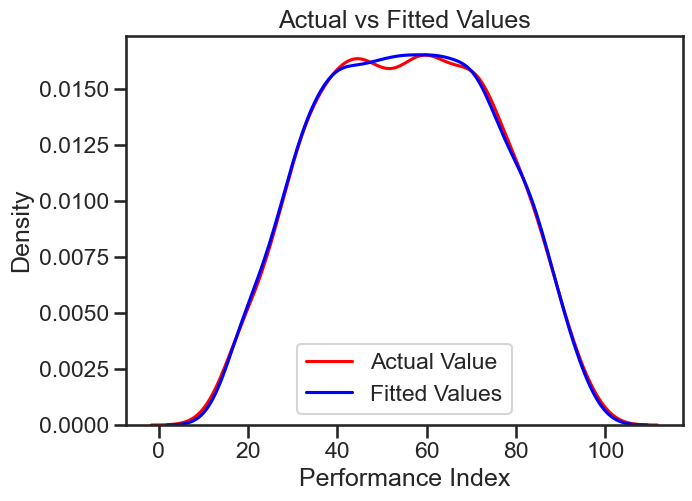

In [922]:
print ("R2 Score:", best_lr.score(x_test, y_test)) # Print the R2 Score
predicted = best_lr.predict(x_test) # Fit the model on the test set
plot_distribution(y_test, predicted) # Plot distribution against actual values

Instead of training multivariate regression, determine the R2 scores of each feature with their optimized models. 

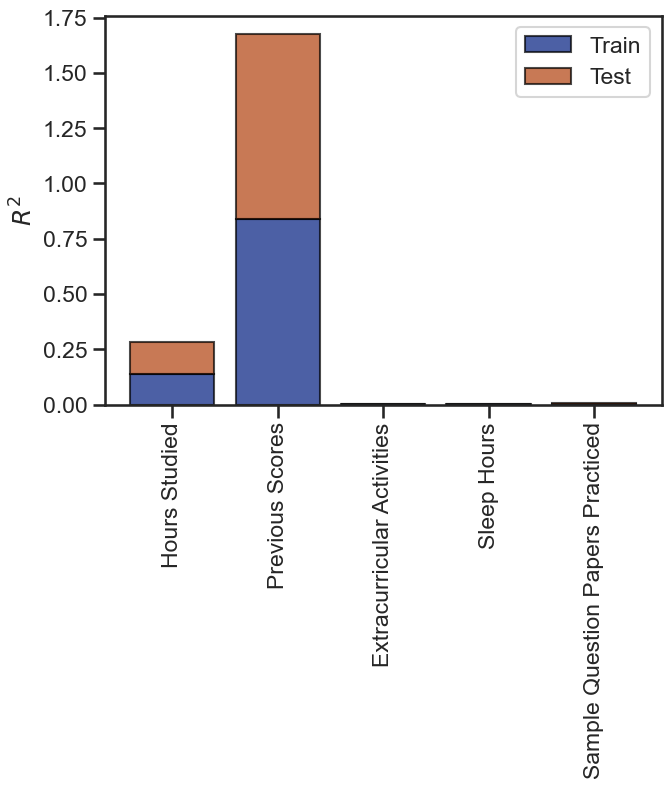

Training R^2 mean value: 0.1959731422299394
      Testing R^2 mean value: 0.19805117206887907
Training R^2 max value: 0.8377492983283459
      Testing R^2 max value: 0.8368372541263911


In [923]:
# List all features
features=list(x)

# Store R2 scores for training and testing sets
R_2_train=[]
R_2_test=[]

# Each iteration builds and evaluates a model using only one predictor
for feature in features:
    # Hyperparameters to tune using GridSearchCV
    param_grid = {
    "polynomial__degree": [1,2,3,4,5], # Degree of the polynomial feature expansion
    "model__positive":[True, False]} # Forces regression coefficients to be non-negative

    steps = [('polynomial', PolynomialFeatures(include_bias=False,degree=2)), # Create nonlinear feature transformations
             ('scaler', StandardScaler()), # Normalize feature magnitudes
             ('model', LinearRegression())] # Fit regression model
    
    pipe=Pipeline(steps) # Define the pipeline
    search = GridSearchCV(pipe, param_grid, n_jobs=2) # Define GridSearchCV
    search.fit(x_train[[feature]],y_train) # Run GridSearhCV
    best_feature = search.best_estimator_ # Extract the best model optimized by GridSearchCV
    
    R_2_train.append(best_feature.score(x_train[[feature]],y_train)) # Evaluate the best approach on training data
    R_2_test.append(best_feature.score(x_test[[feature]],y_test)) # Evaluate the best approach on test data

# Plot stacked bar chart of R2 scores for each feature
plt.bar(features, R_2_train, label="Train", alpha=0.7, edgecolor="black") # Train
plt.bar(features, R_2_test, label="Test", bottom=R_2_train, alpha=0.7, edgecolor="black") # Test

# Customize plot appearance
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()

# Display summary statistics
print("Training R^2 mean value: {}\n\
      Testing R^2 mean value: {}"
      .format(str(np.mean(R_2_train)),
              str(np.mean(R_2_test))))
print("Training R^2 max value: {}\n\
      Testing R^2 max value: {}"
      .format(str(np.max(R_2_train)),
              str(np.max(R_2_test))))

Using K Fold to perform cross validation and assess how well the model generalizes.

In [924]:
# Define 3-fold K Fold Cross Validation
kf = KFold(shuffle=True, random_state=6767, n_splits=3)

# Preview the first 10 train/test indices for each split
for train_index, test_index in kf.split(x):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:", test_index[:10], len(test_index))
    print("")
    
scores = []

for train_index, test_index in kf.split(x):
    x_train_kf, x_test_kf, y_train_kf, y_test_kf = (x.iloc[train_index, :], # Train test splits
                                        x.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

    pipe.fit(x_train_kf, y_train_kf) # Train pipeline
    y_pred = pipe.predict(x_test_kf)
    score = r2_score(y_test_kf.values, y_pred) # Evaluate model
    scores.append(score)
scores

Train index: [ 0  1  2  4  7  8  9 11 12 13] 6666
Test index: [ 3  5  6 10 17 21 23 26 27 36] 3334

Train index: [ 0  1  2  3  5  6  7  9 10 12] 6667
Test index: [ 4  8 11 18 19 20 22 25 28 29] 3333

Train index: [ 3  4  5  6  8 10 11 17 18 19] 6667
Test index: [ 0  1  2  7  9 12 13 14 15 16] 3333



[0.9887858856883706, 0.9886172447501796, 0.9887229740156729]

K Fold cross validation can also be compressed into a single function.

In [925]:
kf = KFold(shuffle=True, random_state=6767, n_splits=3)
scores = cross_val_score(lr, x, y, scoring ="r2", cv=kf)

def display_scores(scores, print_=False):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.98878589 0.98861724 0.98872297]
Mean: 0.988708701484741
Standard deviation: 6.958314145863333e-05


The larger the fold, the more accurate our estimate of the model's performance.

With a higher k, each training set contains more data nad each test set is smaller.

This reduces the variance of performance scores across folds, making the average score a more reliable estimate of the model's performance.

In [926]:
# Use Scikit-learn's K-Fold cross-validation method to assess model performance
kf = KFold(shuffle=True, random_state=6767, n_splits=50)
scores = cross_val_score(lr, x, y, scoring ="r2", cv=kf)

display_scores(scores)

Scores: [0.99072262 0.9896883  0.99016963 0.98899362 0.98635837 0.99063505
 0.98890937 0.98712049 0.99060611 0.98926573 0.98762408 0.98837801
 0.98831216 0.98803565 0.98846998 0.98614267 0.98762189 0.98974206
 0.98876976 0.98819988 0.98966464 0.98887175 0.98924512 0.98632964
 0.98883224 0.98705673 0.98976873 0.98814939 0.9899185  0.9906163
 0.98731675 0.98609356 0.98898532 0.98882177 0.98765985 0.99164183
 0.9919311  0.9880593  0.99054451 0.98856505 0.98859662 0.98716404
 0.98932373 0.98789086 0.98883524 0.98514482 0.98946932 0.98647998
 0.98897498 0.98743555]
Mean: 0.9886230528651734
Standard deviation: 0.0014557385086942317


We can perform the same function with a pipeline, including the standard scaler.

We'll use cross_val_predict for this, which puts all predictions back into a single array for R2 evaluation (as opposed to cross_val_score separately evaluating each fold).

In [927]:
pipe = Pipeline([('scaler', s), ('regression', lr)])
kf = KFold(shuffle=True, random_state=6767, n_splits=50)
predictions = cross_val_predict(pipe, x, y, cv=kf)

print (f"Pipeline R2 score: {r2_score(y, predictions)}\
       \nOriginal R2 Score: {np.mean(scores)}")

Pipeline R2 score: 0.9887405984689962       
Original R2 Score: 0.9886230528651734


Hyperparameter Tuning uses cross validation to determine hyperparameters that generalize well.

Now observe lasso regression, which improves generalization and may predict better on new data.

Create an array of numbers equally spaced on a logarithmic scale called "alpha", which will control regularization strength.

In [928]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [929]:
scores = []
coefs = []

kf = KFold(shuffle=True, random_state=6767, n_splits=3)

for alpha in alphas:

    las = Lasso(alpha=alpha, max_iter=100000)

    pipe = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])
    
    predictions = cross_val_predict(pipe, x, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

list(zip(alphas,scores))

[(np.float64(1e-09), 0.9887116549082707),
 (np.float64(1e-08), 0.9887116549083009),
 (np.float64(1e-07), 0.9887116549090663),
 (np.float64(1e-06), 0.9887116549242111),
 (np.float64(1e-05), 0.9887116550776016),
 (np.float64(0.0001), 0.988711655919941),
 (np.float64(0.001), 0.9887116523837555),
 (np.float64(0.01), 0.9887104210638912),
 (np.float64(0.1), 0.9885785120644379),
 (np.float64(1.0), 0.9803683396349347)]

In [930]:
# Examine the individual coefficients for lasso regression with no CV or StandardScaler
dict(zip(x.columns, Lasso(alpha=1e-6).fit(x, y).coef_))

{'Hours Studied': np.float64(2.852981910629737),
 'Previous Scores': np.float64(1.018434190237019),
 'Extracurricular Activities': np.float64(0.6128935638117717),
 'Sleep Hours': np.float64(0.48055938053779956),
 'Sample Question Papers Practiced': np.float64(0.1938020308455193)}

In [931]:
# Examine the individual coefficients for lasso regression with no CV or StandardScaler
dict(zip(x.columns, Lasso(alpha=1.0).fit(x, y).coef_))

{'Hours Studied': np.float64(2.7065633776387847),
 'Previous Scores': np.float64(1.0153426356517725),
 'Extracurricular Activities': np.float64(0.0),
 'Sleep Hours': np.float64(0.12986188655745085),
 'Sample Question Papers Practiced': np.float64(0.07684487358777345)}

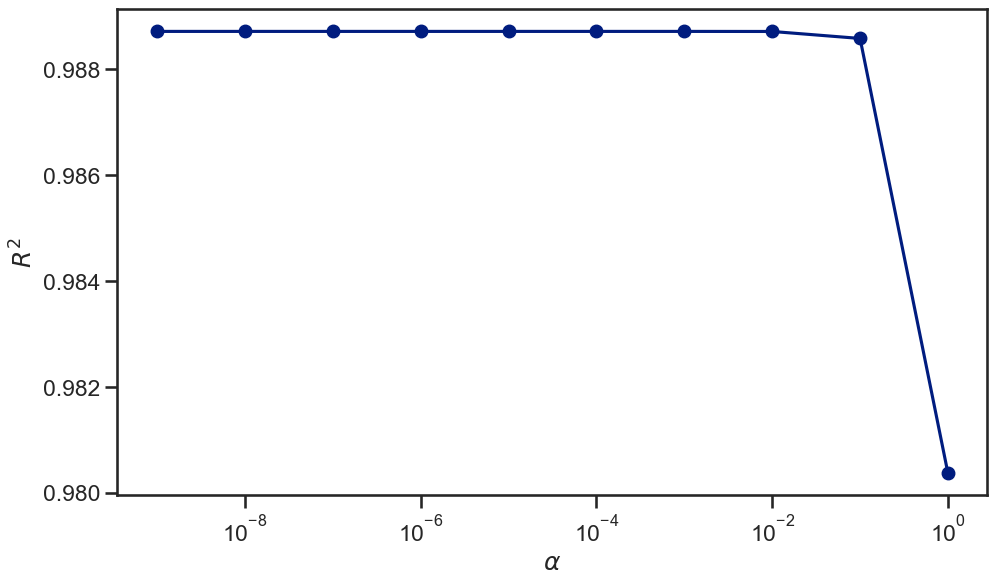

In [932]:
# R2 vs Lasso regularization strength

plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, "-o")
plt.xlabel("$\\alpha$")
plt.ylabel("$R^2$");

Also observe lasso regression when done with polynomial feature engineering.

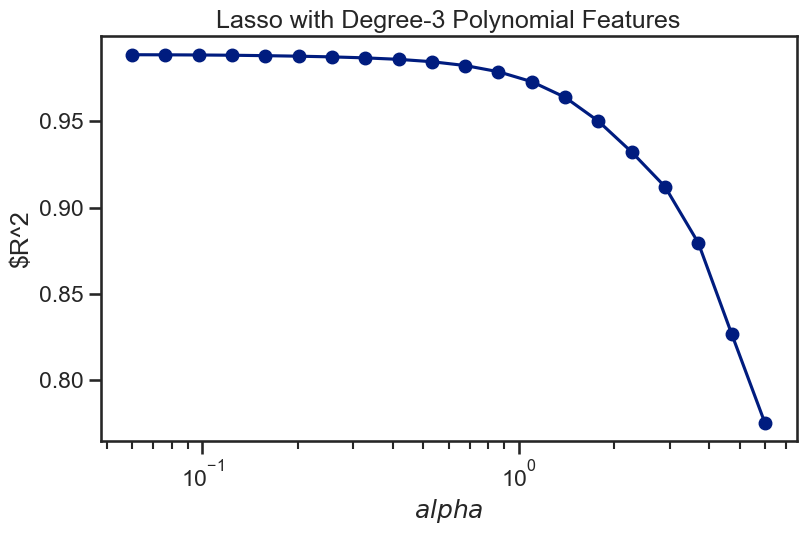

In [933]:
# Try lasso on degree-3 polynomial feature and see alpha's effect on R2

scores = []

pf = PolynomialFeatures(degree=3)
alphas = np.geomspace(0.06, 6.0, 20)

kf = KFold(shuffle=True, random_state=6767, n_splits=3)

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf), # polynomial feature engineering
        ("lasso_regression", las)])
    predictions = cross_val_predict(estimator, x, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

# Plot R2 vs alpha
plt.figure(figsize=(8,5))
plt.semilogx(alphas, scores, "-o")
plt.xlabel(r"$alpha$")
plt.ylabel(r"$R^2")
plt.title("Lasso with Degree-3 Polynomial Features");

In [934]:
best_lasso = Pipeline([
    ("scaler", s),
    ("lasso_regression", Lasso(alpha=0.0001))])

best_lasso.fit(x_train, y_train)

print (f"Best estimator score: {best_lasso.score(x_test,y_test)}")

# Print results
coefficients = best_lasso.named_steps["lasso_regression"].coef_
coef_dict = dict(zip(x.columns, coefficients)) # Map them to the feature names
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef}")

Best estimator score: 0.9892895510324387
Hours Studied: 7.376295327341729
Previous Scores: 17.66002447687411
Extracurricular Activities: 0.3151736902048998
Sleep Hours: 0.8001379764380904
Sample Question Papers Practiced: 0.5339303328857381


We can also prevent overfitting with Ridge instead of Lasso.

In contrast to Lasso, Ridge never zeros out coefficients, but may add a penalty proportional to the square of the coefficients.

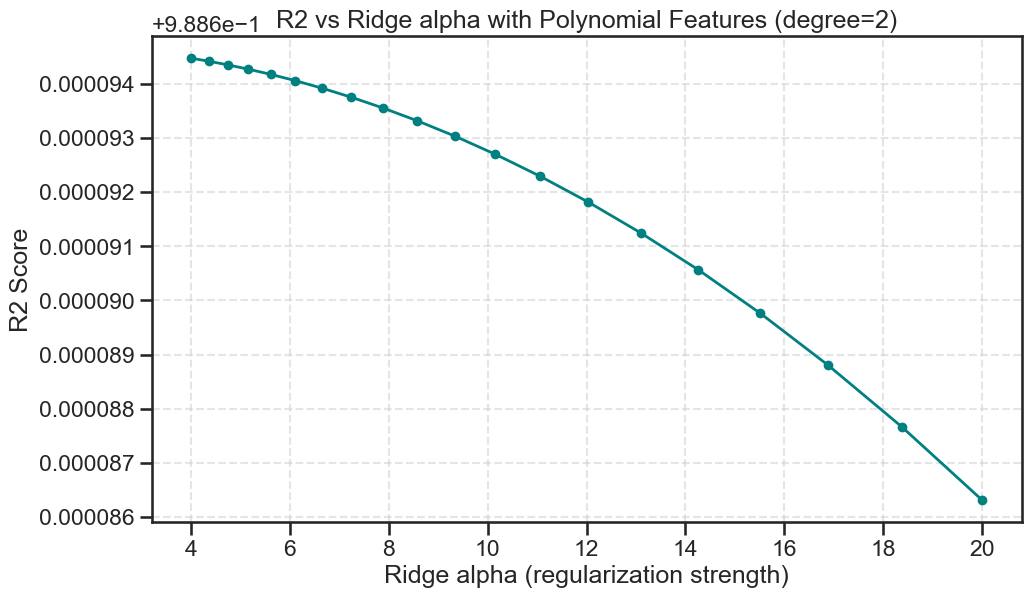

In [935]:
# Create polynomial features (degree=2)
pf = PolynomialFeatures(degree=2)

# Define a range of alpha values for Ridge regression
alphas = np.geomspace(4,20,20)

# 3-fold cross-validation
kf = KFold(shuffle=True, random_state=6767, n_splits=3)

scores = []

for alpha in alphas:
    # Initialize ridge regression
    ridge = Ridge(alpha = alpha, max_iter=100000)

    # Build a pipeline
    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])
    
    # Get cross-validation predictions on the dataset
    predictions = cross_val_predict(estimator, x, y, cv = kf)
    
    # Calculate R2 Score
    score = r2_score(y, predictions)
    scores.append(score)

# Plot R2 vs alpha
plt.figure(figsize=(10,6))
plt.plot(alphas, scores, "-o", color="teal", markersize=6, linewidth=2)
plt.xlabel("Ridge alpha (regularization strength)")
plt.ylabel("R2 Score")
plt.title("R2 vs Ridge alpha with Polynomial Features (degree=2)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Use GridSearchCV to optimize hyperparameters.

In [936]:
pipe = Pipeline([("scaler", StandardScaler()),
                     ("polynomial_features", PolynomialFeatures()),
                     ("ridge_regression", Ridge())])

params = {
    "polynomial_features__degree" : [1,2,3],
    'ridge_regression__alpha': np.geomspace(4,20,20)
}

kf = KFold(shuffle=True, random_state=6767, n_splits=3)

search = GridSearchCV(pipe, params, cv=kf)

search.fit(x_train, y_train)

,estimator,"Pipeline(step...n', Ridge())])"
,param_grid,"{'polynomial_features__degree': [1, 2, ...], 'ridge_regression__alpha': array([ 4. ... 20. ])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [937]:
search.best_score_, search.best_params_

(np.float64(0.9885835124716236),
 {'polynomial_features__degree': 1,
  'ridge_regression__alpha': np.float64(4.0)})

In [938]:
y_pred = search.predict(x_test)

r2_score(y_test, y_pred)

0.9892875730903192

Observe the coefficients on each of the features.

In [939]:
features = search.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(x.columns)[1:]
coefficients = search.best_estimator_.named_steps["ridge_regression"].coef_[1:]

coef_dict = dict(zip(features, coefficients))
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef}")

Hours Studied: 7.372580066215685
Previous Scores: 17.65124613385131
Extracurricular Activities: 0.31514434259817614
Sleep Hours: 0.799913695527385
Sample Question Papers Practiced: 0.5338669378024858


Observe the CV results of my gridsearch for every parameter combination, folds included.

In [940]:
import pandas as pd
df = pd.DataFrame(search.cv_results_)
df[['param_polynomial_features__degree', 'param_ridge_regression__alpha', 'mean_test_score', 'rank_test_score']]

,param_polynomial_features__degree,param_ridge_regression__alpha,mean_test_score,rank_test_score
0,1,4.000000,0.988584,1
1,1,4.353594,0.988583,2
2,1,4.738444,0.988583,3
3,1,5.157315,0.988583,4
4,1,5.613214,0.988583,5
5,1,6.109413,0.988583,6
6,1,6.649475,0.988583,7
7,1,7.237278,0.988582,8
8,1,7.877042,0.988582,9
9,1,8.573360,0.988582,10
